#Final Model
- Consists of 2 parts: Unsupervised Learning part and Supervised Learning part

Unsupervised Learning part
- Autoencoder embeddings
- clustering

Supervised Learning part
- feature selection
- running ML model

### Supervised Learning Part

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

LOADING DATA

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Analytics Project/EDA/song_data_transformed.csv')
df.head()

,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,decade
0,2.585174,0.868312,0.336235,1.590276,0.429502,-1.227755,-0.422918,-0.776569,-0.277259,-0.491799,0.139766,-0.058157,0.573111,0.200898,0.781929
1,2.431351,-2.421427,-0.078151,0.750118,0.224346,0.814495,-0.494386,-0.847012,-0.277260,-0.232784,-1.440773,-1.305936,0.413941,0.200898,0.781929
2,2.277527,-0.799358,0.376662,-1.210251,0.302673,0.814495,-0.322864,-0.986680,-0.276703,-0.629724,-0.841832,1.753530,-0.214086,0.200898,0.781929
3,2.200616,0.282022,-0.345986,0.470065,0.003022,0.814495,2.054246,-0.471933,-0.277236,-0.323439,-0.209616,2.286157,0.213738,0.200898,0.097001
4,1.969881,-0.323811,-0.659303,-1.210251,-0.038232,-1.227755,-0.304173,-0.582575,-0.277274,-0.342865,-0.118111,0.426683,0.632939,0.200898,0.097001


In [4]:
df2 = pd.read_csv('/content/drive/MyDrive/Analytics Project/EDA/song_data_cleaned.csv')
df2.head()

,track_id,track_name,artist_name,popularity,album,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,duration_ms,time_signature,decade
0,1Es7AUAhQvapIcoh3qMKDL,Timeless (with Playboi Carti),"['The Weeknd', 'Playboi Carti']",92,Timeless,0.769,0.722,11,-5.485,0,0.0507,0.05840,0.000003,0.1110,0.570,119.973,audio_features,256000,4,2020
1,7CyPwkp0oE8Ro9Dd5CUDjW,"One Of The Girls (with JENNIE, Lily Rose Depp)","['The Weeknd', 'JENNIE', 'Lily-Rose Depp']",90,The Idol Episode 4 (Music from the HBO Origina...,0.264,0.640,8,-6.221,1,0.0442,0.03930,0.000002,0.1510,0.190,84.828,audio_features,244685,4,2020
2,0VjIjW4GlUZAMYd2vXMi3b,Blinding Lights,['The Weeknd'],88,After Hours,0.513,0.730,1,-5.940,1,0.0598,0.00143,0.000095,0.0897,0.334,171.001,audio_features,200040,4,2020
3,7MXVkk9YMctZqd1Srtv4MB,Starboy,"['The Weeknd', 'Daft Punk']",87,Starboy,0.679,0.587,7,-7.015,1,0.2760,0.14100,0.000006,0.1370,0.486,186.003,audio_features,230453,4,2010
4,2LBqCSwhJGcFQeTHMVGwy3,Die For You,['The Weeknd'],84,Starboy,0.586,0.525,1,-7.163,0,0.0615,0.11100,0.000000,0.1340,0.508,133.629,audio_features,260253,4,2010


AUTOENCODER

- training a "denoising" autoencoder to ensure model will train well

In [5]:
def zero_out(df, num_features_to_zero=2):
    df_zeroed = df.copy()
    num_rows, num_cols = df_zeroed.shape

    for row_idx in range(num_rows):
        # Randomly choose `num_features_to_zero` columns without replacement
        random_columns = np.random.choice(num_cols, size=num_features_to_zero, replace=False)
        # Set the selected columns to 0 for the current row
        df_zeroed.iloc[row_idx, random_columns] = 0

    return df_zeroed



In [6]:
# training/validation data
df_np = df.to_numpy()

df_zeroed = zero_out(df)
df_zeroed_np = df_zeroed.to_numpy()

indices = np.random.permutation(df.shape[0])

train_end = int(0.7 * len(df_np))

train_indices = indices[:train_end]
valid_indices = indices[train_end:]

data_train_TRUE = df_np[train_indices]
data_valid_TRUE = df_np[valid_indices]

data_train_zerod = df_zeroed_np[train_indices]
data_valid_zerod = df_zeroed_np[valid_indices]

In [7]:
# building a simple model
import torch
from torch import nn

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(15, 4096),
            nn.ReLU(),
            nn.Linear(4096,2048),
            nn.ReLU(),
            nn.Linear(2048,1024),
            nn.Dropout(0.05),
            nn.ReLU(),
            nn.Linear(1024,256),
            nn.ReLU(),
            nn.Linear(256,16)
        )
        self.decoder = nn.Sequential(
            nn.Linear(16,256),
            nn.ReLU(),
            nn.Linear(256,1024),
            nn.Dropout(0.05),
            nn.ReLU(),
            nn.Linear(1024,2048),
            nn.ReLU(),
            nn.Linear(2048,4096),
            nn.ReLU(),
            nn.Linear(4096, 15) # outputs are norm. distb'd. between [-inf,inf] with mean 0
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [8]:
def train(model, train_true, valid_true, train_zerod, valid_zerod, batch_size=64, num_epochs=5, learning_rate=0.005):
    import torch
    import torch.nn as nn
    from torch.utils.data import DataLoader, TensorDataset
    import matplotlib.pyplot as plt
    from torch.optim.lr_scheduler import StepLR as StepLR

    np.random.seed(42)

    # using GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Create DataLoaders for mini-batching

    train_zerod_tensor = torch.from_numpy(train_zerod).float().to(device)
    train_true_tensor = torch.from_numpy(train_true).float().to(device)
    valid_zerod_tensor = torch.from_numpy(valid_zerod).float().to(device)
    valid_true_tensor = torch.from_numpy(valid_true).float().to(device)

    train_dataset = TensorDataset(train_zerod_tensor, train_true_tensor)
    valid_dataset = TensorDataset(valid_zerod_tensor, valid_true_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

    model = model.to(device)
    criterion = nn.MSELoss()  # Mean Squared Error for regression
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = 1e-4)
    scheduler = StepLR(optimizer, step_size= 30, gamma=0.5)

    epochs, train_loss, val_loss = [], [], []

    for epoch in range(num_epochs):
        # Training loop with mini-batching
        for data,target in train_loader:
            data,target = data.to(device),target.to(device)
            recon = model(data)
            loss = criterion(recon, target)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        scheduler.step()

        # Average training loss
        total_train_loss = 0
        with torch.no_grad():
          for data, target in train_loader:
            data,target = data.to(device),target.to(device)
            recon = model(data)
            loss = criterion(recon, target)
            total_train_loss += loss.item()
        train_loss.append(total_train_loss / len(train_loader))

        # Validation loop
        total_val_loss = 0
        with torch.no_grad():
            for data,target in valid_loader:
                data,target = data.to(device),target.to(device)
                recon = model(data)
                loss = criterion(recon, target)
                total_val_loss += loss.item()
        val_loss.append(total_val_loss / len(valid_loader))

        # Logging
        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss[-1]:.4f}, Validation Loss: {val_loss[-1]:.4f}")

        # Save model every 10 epochs
        if (epoch + 1) % 10 == 0:
            torch.save(model.state_dict(), f"/content/drive/MyDrive/Analytics Project/Final Model/model_epoch_{epoch + 1}.pt")

        epochs.append(epoch + 1)

    # Plot Loss
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_loss, label="Training Loss")
    plt.plot(epochs, val_loss, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


Using device: cuda
Epoch [1/70], Train Loss: 0.2261, Validation Loss: 0.2353
Epoch [2/70], Train Loss: 0.1768, Validation Loss: 0.1849
Epoch [3/70], Train Loss: 0.1600, Validation Loss: 0.1706
Epoch [4/70], Train Loss: 0.1573, Validation Loss: 0.1698
Epoch [5/70], Train Loss: 0.1496, Validation Loss: 0.1645
Epoch [6/70], Train Loss: 0.1513, Validation Loss: 0.1686
Epoch [7/70], Train Loss: 0.1427, Validation Loss: 0.1597
Epoch [8/70], Train Loss: 0.1507, Validation Loss: 0.1683
Epoch [9/70], Train Loss: 0.1381, Validation Loss: 0.1576
Epoch [10/70], Train Loss: 0.1359, Validation Loss: 0.1577
Epoch [11/70], Train Loss: 0.1363, Validation Loss: 0.1573
Epoch [12/70], Train Loss: 0.1296, Validation Loss: 0.1528
Epoch [13/70], Train Loss: 0.1325, Validation Loss: 0.1565
Epoch [14/70], Train Loss: 0.1263, Validation Loss: 0.1518
Epoch [15/70], Train Loss: 0.1333, Validation Loss: 0.1592
Epoch [16/70], Train Loss: 0.1274, Validation Loss: 0.1527
Epoch [17/70], Train Loss: 0.1214, Validation 

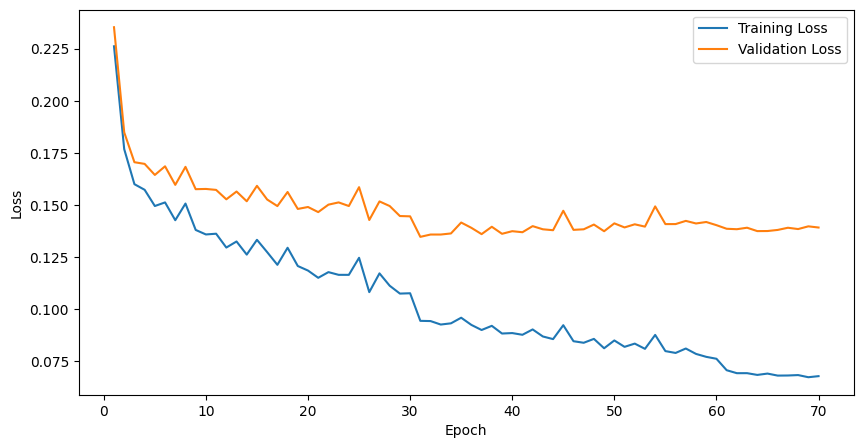

In [9]:
model = AutoEncoder()
train(model, data_train_TRUE, data_valid_TRUE, data_train_zerod, data_valid_zerod, batch_size=64, num_epochs=70, learning_rate=0.0003)

In [10]:
# getting best model
Bestmodel = AutoEncoder()
Bestmodel.load_state_dict(torch.load('/content/drive/MyDrive/Analytics Project/Final Model/model_epoch_70.pt', weights_only=True))



<All keys matched successfully>

In [11]:
# getting song embeddings for each song

  # gettting encoder
encoder = Bestmodel.encoder

  # getting tensors for df
df_np = df.to_numpy()
data_tensor = torch.tensor(df_np, dtype=torch.float32)

# Get embeddings
with torch.no_grad():
    encoder.eval()
    embeddings = encoder(data_tensor)

# getting an embedding dataframe
embeddings_np = embeddings.numpy()
embeddings_df = pd.DataFrame(embeddings_np)

# Display embeddings
embeddings_df # each column is 1 song embedding


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.205892,-1.186807,-1.322969,1.836674,-0.761467,1.016338,0.343939,-0.641770,-1.244853,0.032225,-0.083590,0.109333,-1.229989,0.467241,-0.931398,0.348655
1,-0.593731,-0.635856,-0.773345,2.639962,-0.138382,-0.540690,0.237290,1.801523,-1.116118,0.791069,2.203366,-0.323164,-0.929569,-0.516826,0.015373,0.927742
2,0.173905,-1.133083,-1.391544,1.632384,-0.618129,-1.761166,-0.324237,-0.001533,-0.028028,0.729641,-0.193491,-0.538338,-0.043552,-0.952788,-0.425755,-0.215748
3,0.461225,-0.776190,-1.767179,1.033922,-2.188571,-1.118790,0.061110,-0.417732,-0.225430,-0.687797,-0.204192,-0.529886,-0.009035,-0.741487,-0.705713,0.539155
4,0.287184,-1.210730,-1.072816,1.114823,-0.731645,-0.098843,-0.785394,1.028278,-0.316469,0.054239,-0.737461,0.126853,-0.440811,0.227257,-0.935779,0.033900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22075,0.333873,1.089304,0.865304,-1.549599,0.720961,0.100487,2.422158,0.361648,1.484165,-0.218480,0.210634,-0.566554,1.020676,-0.328606,0.052581,0.239107
22076,-0.930942,0.713286,1.781713,-1.656850,0.938812,-1.304592,2.148712,1.363971,0.990385,1.521894,1.456104,0.631098,-0.979640,-0.606972,-0.005423,0.852235
22077,0.298470,0.900061,1.744507,-2.206388,0.819474,0.951964,0.948841,3.441778,1.413278,0.077689,-0.804195,0.546709,0.344820,1.055140,-1.394012,-0.314501
22078,0.311375,1.083431,0.922835,-1.977566,0.829019,0.817042,1.135887,-0.715015,0.727464,1.190086,-0.591577,1.229852,0.434970,0.296462,-1.054489,0.020339


### Clustering each song

--> used k-means clustering since density-based clustering wasn't working very well

--> used elbow plot for hyper-parameter tuning

In [12]:
# standardizing song embeddings
from sklearn.preprocessing import StandardScaler
scaler1 = StandardScaler()
scaled_embeddings = scaler1.fit_transform(embeddings_np)

# clustering using kmeans - (dbscan isnt working well)
from sklearn.cluster import KMeans

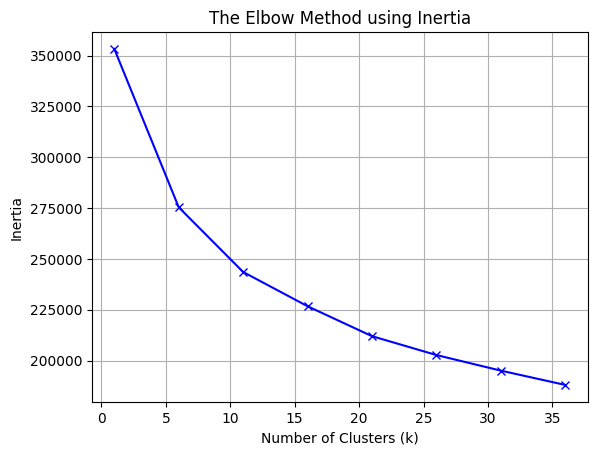

In [13]:
#hyperparamter tuning for optimal k (using interia)
inertias = []
K = []
for k in range (1,40,5):
  K.append(k)
  kmeans_model = KMeans(n_clusters = k)
  inertias.append(kmeans_model.fit(scaled_embeddings).inertia_)

# Plotting elbow plot
plt.plot(K, inertias, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.grid()
plt.show()

The elbow point seems to occur near k = 5, so this k value will be chosen

In [14]:
# performing clustering
kmeans_model = KMeans(n_clusters = 1, random_state=1)
kmeans_model.fit_transform(scaled_embeddings)
cluster_labels = kmeans_model.labels_

# Add cluster labels to embedding dataframe
embeddings_df['Cluster'] = cluster_labels

# Count the number of points in each cluster
cluster_counts = embeddings_df['Cluster'].value_counts()
print("Cluster Counts:\n", cluster_counts)


Cluster Counts:
 Cluster
0    22080
Name: count, dtype: int64


In [ ]:
#Visualizing the Clusters with t-SNE
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3, perplexity=30, random_state=42)
embeddings_3d = tsne.fit_transform(scaled_embeddings)

In [ ]:
projection = pd.DataFrame(columns=['x', 'y','z'], data=embeddings_3d)
projection['cluster'] = embeddings_df['Cluster']
projection['track_name'] = df2['track_name']
projection['artist_name'] = df2['artist_name']

# Step 4: Create a 3D plot
fig = plt.figure(figsize=(12, 8))

fig = px.scatter_3d(
    projection, x='x', y='y',z='z', color='cluster', hover_data=['x', 'y','z', 'track_name', 'artist_name'])
fig.show()

<Figure size 1200x800 with 0 Axes>

### Getting potential song recommendations from NN to playlist


In [15]:
playlist = pd.read_csv('/content/drive/MyDrive/Analytics Project/Initial Model/playlist_df _TRIAL.csv')
playlist['release_date'] = playlist['release_date'].astype('datetime64[ns]')
playlist['release_date'] = playlist['release_date'].dt.year

In [16]:
playlist_numeric = playlist.select_dtypes(include=np.number)
playlist_numeric['decade'] = (playlist_numeric['release_date'] // 10) * 10
playlist_numeric = playlist_numeric.dropna()
playlist_numeric.drop(columns=['release_date'], inplace=True)
playlist_numeric.head()

,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,decade
0,0,0.497,0.849,9,-5.352,1,0.0612,0.00985,0.000000,0.106,0.720,169.937,261532,4,1980
1,84,0.574,0.913,6,-4.793,0,0.1330,0.06100,0.001580,0.156,0.423,115.728,208400,4,1970
2,83,0.532,0.887,0,-3.757,1,0.0335,0.07780,0.000206,0.294,0.794,122.509,249293,4,1980
3,85,0.505,0.754,4,-7.435,1,0.0366,0.13200,0.000000,0.204,0.510,119.204,249600,4,1980
4,69,0.391,0.402,0,-9.961,0,0.0539,0.28900,0.000000,0.243,0.228,143.879,354320,4,1970


In [17]:
# Calculate the mean of each numeric column
playlist_mean = playlist_numeric.mean()

# Calculate the mode for categorical/ordinal columns
most_common_key = playlist_numeric['key'].mode()[0]
most_common_mode = playlist_numeric['mode'].mode()[0]
most_common_time_signature = playlist_numeric['time_signature'].mode()[0]

# Create a DataFrame to display both mean and most common values
playlist_summary = playlist_mean.to_frame(name='mean_value').T
playlist_summary['key'] = most_common_key
playlist_summary['mode'] = most_common_mode
playlist_summary['time_signature'] = most_common_time_signature

playlist_summary

,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,decade
mean_value,66.531073,0.516922,0.736696,9,-7.757869,1,0.058049,0.131311,0.032966,0.187681,0.553875,126.205465,256540.579096,4,1982.570621


In [18]:
# import scaler used to scale 25,000 song data
import joblib
scaler5 = joblib.load('/content/drive/MyDrive/Analytics Project/Final Model/scaler.pkl')

# song_data = pd.read_csv('/content/drive/MyDrive/Analytics Project/EDA/song_data_cleaned.csv')
# song_data= song_data.select_dtypes(include=np.number)
# song_data = song_data.dropna()
# song_data_sub = song_data

# scaler5 = StandardScaler()
# scaler5.fit(song_data_sub.to_numpy())


In [19]:
playlist_summary_scaled = scaler5.transform(playlist_summary)
playlist_summary_scaled

array([[ 0.62631785, -0.77380653,  0.41050228,  1.03017046, -0.20404855,
         0.81449502, -0.34211481, -0.50766616, -0.07971814,  0.00473565,
         0.07269726,  0.16311943,  0.58071559,  0.20089808, -1.78171563]])

In [20]:
# encoding playlist summary
playlist_tensor = torch.from_numpy(playlist_summary_scaled).float()
with torch.no_grad():
  encoder.eval()
  mean_playlist_embedding = encoder(playlist_tensor)
mean_playlist_embedding = scaler1.transform(mean_playlist_embedding.numpy())

In [21]:
# getting cluster, mean playlist embedding belongs to
predicted_cluster = kmeans_model.predict(mean_playlist_embedding)
predicted_label = predicted_cluster[0]
print(predicted_label)

0


In [22]:
# getting 10 nearest songs to mean playlist embedding to provide as potential song recommendations
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity

cluster_embeddings = embeddings_df[embeddings_df['Cluster'] == predicted_label]
embeddings_from_cluster = cluster_embeddings.drop(columns=['Cluster'])

#song_distances = pairwise_distances(embeddings_from_cluster.to_numpy(), mean_playlist_embedding, metric='euclidean').flatten()
song_distances = cosine_similarity(embeddings_from_cluster.to_numpy(), mean_playlist_embedding).flatten() # cosine similarity seems to be working pretty well

In [23]:
song_data = df2

In [24]:
# getting song information from cluster
cluster_song_data = song_data.loc[cluster_embeddings.index]
cluster_song_data['distance'] = song_distances

# Filter out songs already in the playlist from cluster
playlist_song_ids = playlist['track_id'].tolist()
cluster_song_data = cluster_song_data[~cluster_song_data['track_id'].isin(playlist_song_ids)]

# Sort by distance to find the 20 closest songs in cluster to mean song embedding
closest_songs = cluster_song_data.nlargest(20, 'distance')

# Display the closest songs
closest_songs

,track_id,track_name,artist_name,popularity,album,danceability,energy,key,loudness,mode,...,acousticness,instrumentalness,liveness,valence,tempo,type,duration_ms,time_signature,decade,distance
8267,4ZD6SiaJi75smnel0d7jl3,Spiderwebs,['No Doubt'],61,Tragic Kingdom,0.490,0.852,10,-7.192,1,...,0.037600,0.000002,0.1260,0.663,143.248,audio_features,266760,4,1990,0.848809
12684,5vYA1mW9g2Coh1HUFUSmlb,3AM,['Matchbox Twenty'],71,Yourself or Someone Like You,0.521,0.673,8,-8.685,1,...,0.005730,0.000000,0.1200,0.543,108.031,audio_features,225947,4,1990,0.832132
7979,5JGdpqo9wrRtOZtui5GShI,Just Like Jesse James,['Cher'],58,Heart Of Stone,0.400,0.563,8,-10.233,1,...,0.170000,0.000000,0.1330,0.442,138.006,audio_features,245733,4,1980,0.831676
3123,7sNhXWrg9eW3qRqeuePaIC,Orange Crush - Remastered 2013,['R.E.M.'],58,Green (Remastered),0.568,0.701,9,-10.453,1,...,0.000613,0.002580,0.1700,0.638,120.678,audio_features,231640,4,1980,0.818322
2311,1sTsuZTdANkiFd7T34H3nb,Human,['The Killers'],73,Day & Age (Bonus Tracks),0.557,0.800,10,-8.477,1,...,0.001320,0.001200,0.0906,0.582,135.470,audio_features,245373,4,2000,0.814999
5558,2sKo5u6IppUEudIz265wYa,Yo Te Amo,['Chayanne'],66,Simplemente,0.573,0.642,11,-6.873,1,...,0.189000,0.000000,0.2210,0.492,140.264,audio_features,288947,4,2000,0.813777
6019,1H4idkmruFoJBg1DvUv2tY,Band On The Run - 2010 Remaster,"['Paul McCartney', 'Wings']",68,Band On The Run (Standard),0.479,0.601,7,-8.806,1,...,0.082300,0.001410,0.1110,0.669,124.966,audio_features,313027,4,1970,0.812661
3326,6F9yAYUaNbUhdlQyt5uZ3b,La Incondicional,['Luis Miguel'],75,Busca Una Mujer,0.374,0.727,10,-4.352,1,...,0.237000,0.000000,0.1340,0.283,155.127,audio_features,257027,4,1980,0.803359
1392,5BckPAYcKEJuYs1eV1BHHe,Take A Chance On Me,['ABBA'],74,The Album,0.684,0.675,11,-8.123,1,...,0.163000,0.000000,0.2420,0.924,107.064,audio_features,243933,4,1970,0.788345
11859,0aAR5HogGoT68EWFbyRFqx,What A Feeling,['Irene Cara'],67,What A Feeling,0.532,0.729,10,-6.840,1,...,0.382000,0.000000,0.3660,0.595,121.970,audio_features,244533,4,2000,0.785832


# TESTING FULL MODEL

In [25]:
def get_top_20_recommendations(playlist_df, song_data):
    unsupervised_df = playlist_df[playlist_df['in_playlist'] == 1].reset_index(drop=True)
    unsupervised_df = unsupervised_df.drop(columns=['in_playlist'])
    playlist_numeric = unsupervised_df.select_dtypes(include=np.number)
    playlist_numeric['decade'] = (playlist_numeric['release_date'] // 10) * 10
    playlist_numeric = playlist_numeric.dropna()
    playlist_numeric.drop(columns=['release_date'], inplace=True)

    playlist_mean = playlist_numeric.mean()

    # Calculate the mode for categorical/ordinal columns
    most_common_key = playlist_numeric['key'].mode()[0]
    most_common_mode = playlist_numeric['mode'].mode()[0]
    most_common_time_signature = playlist_numeric['time_signature'].mode()[0]

    # Create a DataFrame to display both mean and most common values
    playlist_summary = playlist_mean.to_frame(name='mean_value').T
    playlist_summary['key'] = most_common_key
    playlist_summary['mode'] = most_common_mode
    playlist_summary['time_signature'] = most_common_time_signature

    playlist_summary_scaled = scaler5.transform(playlist_summary)

    playlist_tensor = torch.from_numpy(playlist_summary_scaled).float()
    with torch.no_grad():
        encoder.eval()
        mean_playlist_embedding = encoder(playlist_tensor)
    mean_playlist_embedding = scaler1.transform(mean_playlist_embedding.numpy())

    predicted_cluster = kmeans_model.predict(mean_playlist_embedding)
    predicted_label = predicted_cluster[0]

    cluster_embeddings = embeddings_df[embeddings_df['Cluster'] == predicted_label]
    embeddings_from_cluster = cluster_embeddings.drop(columns=['Cluster'])

    #song_distances = pairwise_distances(embeddings_from_cluster.to_numpy(), mean_playlist_embedding, metric='euclidean').flatten()
    song_distances = cosine_similarity(embeddings_from_cluster.to_numpy(), mean_playlist_embedding).flatten() # cosine similarity seems to be working pretty well

    # getting song information from cluster
    cluster_song_data = song_data.loc[cluster_embeddings.index]
    cluster_song_data['distance'] = song_distances

    # Filter out songs already in the playlist from cluster
    playlist_song_ids = playlist['track_id'].tolist()
    cluster_song_data = cluster_song_data[~cluster_song_data['track_id'].isin(playlist_song_ids)]

    # Sort by distance to find the 20 closest songs in cluster to mean song embedding
    closest_songs = cluster_song_data.nlargest(20, 'distance')

    return closest_songs

In [26]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from scipy.stats import uniform, randint
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score

def test_recommendation_quality(playlist_to_use, top_20_songs):

    X_vals = playlist_to_use.drop(['track_id', 'track_name', 'artist_name', 'album', 'uri', 'type', 'id', 'track_href', 'analysis_url', 'in_playlist', 'loudness'], axis = 1)
    X_vals['decade'] = (X_vals['release_date'] // 10) * 10 #HAD TO USE DECADE TO MATCH THE TOP_20_SONGS DATA
    X_vals = X_vals.drop(columns=['release_date'])
    y_vals = playlist_to_use['in_playlist']
    X_train, X_test, y_train, y_test = train_test_split(X_vals, y_vals, test_size=0.3, random_state=21)
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    # XGBoost Classifier
    XGB = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

    # Define distributions for hyperparameter tuning
    distributions = {
        'n_estimators': randint(50, 300),  # Number of trees
        'max_depth': randint(1, 15),      # Maximum tree depth
        'learning_rate': uniform(0.01, 0.5),  # Learning rate
        'subsample': uniform(0.5, 0.5),   # Subsample ratio of the training instances
        'colsample_bytree': uniform(0.5, 0.5)  # Subsample ratio of columns
    }

    # Randomized search on hyperparameters
    XGB_search = RandomizedSearchCV(
        XGB,
        distributions,
        cv=5,
        verbose=2,
        random_state=42,
        n_jobs=-1,
        return_train_score=True,
        n_iter=500
    )

    searchXGB = XGB_search.fit(X_train, y_train)

    # Retrain the best model
    best_clf = XGBClassifier(
    n_estimators=searchXGB.best_params_['n_estimators'],
    max_depth=searchXGB.best_params_['max_depth'],
    learning_rate=searchXGB.best_params_['learning_rate'],
    subsample=searchXGB.best_params_['subsample'],
    colsample_bytree=searchXGB.best_params_['colsample_bytree'],
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
    )

    best_clf.fit(X_train, y_train)

    # Predictions
    y_pred = best_clf.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    #print(f"Accuracy of the XGBClassifier on the test set: {accuracy}")
    #print(f"Precision of the XGBClassifier on the test set: {precision}")
    print('done training')


    top_20_vals = top_20_songs.drop(['track_id', 'track_name', 'artist_name', 'album', 'type', 'loudness'], axis = 1)
    top_20_vals = scaler.transform(top_20_vals)
    top_20_predictions = best_clf.predict_proba(top_20_vals)[:, 1]

    return top_20_predictions, accuracy, precision

In [40]:
def run_on_all_playlists(playlist_list, song_data):
    overall_accuracy = 0
    accyracy_list = []
    precision_list = []

    summary_df = pd.DataFrame(columns=['test accuracy', 'test precision', 'average predicted probabilties'])
    for i in playlist_list:
        playlist_to_use = pd.read_csv(i)
        top_20_songs = get_top_20_recommendations(playlist_to_use, song_data)
        top_20_songs.drop(columns=['distance'], inplace=True)
        top_20_predictions, accuracy, precision = test_recommendation_quality(playlist_to_use, top_20_songs)
        accyracy_list.append(accuracy)
        precision_list.append(precision)
        #print('Accuracy for playlist', i, "is: ", accuracy)
        #print('Precision for playlist', i, "is: ", precision)
        #print(top_20_predictions + 'for playlist ', i)
        #print('Accuracy for playlist', i, "is: ", top_20_predictions.sum()/20)
        overall_accuracy += top_20_predictions.sum()/20
        summary_df = pd.concat([summary_df, pd.DataFrame([{'test accuracy': accuracy, 'test precision': precision, 'average predicted probabilties': top_20_predictions.sum()/20}])], ignore_index=True)

    return summary_df
   # print('Overall accuracy is: ', overall_accuracy/len(playlist_list))

playlist_list = ['/content/drive/MyDrive/Analytics Project/Playlist Datasets to Train ML model/classic_rock.csv',
                 '/content/drive/MyDrive/Analytics Project/Playlist Datasets to Train ML model/workout.csv',
                 '/content/drive/MyDrive/Analytics Project/Playlist Datasets to Train ML model/study.csv',
                 '/content/drive/MyDrive/Analytics Project/Playlist Datasets to Train ML model/raj_study.csv',
                 '/content/drive/MyDrive/Analytics Project/Playlist Datasets to Train ML model/pop.csv',
                 '/content/drive/MyDrive/Analytics Project/Playlist Datasets to Train ML model/old_school_rap.csv',
                 '/content/drive/MyDrive/Analytics Project/Playlist Datasets to Train ML model/new_school_rap.csv',
                 '/content/drive/MyDrive/Analytics Project/Playlist Datasets to Train ML model/latin.csv',
                 '/content/drive/MyDrive/Analytics Project/Playlist Datasets to Train ML model/country.csv',
                 '/content/drive/MyDrive/Analytics Project/Playlist Datasets to Train ML model/house.csv'
]

In [41]:
final_summary_df = run_on_all_playlists(playlist_list, song_data)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:27:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
<ipython-input-40-0b805df3d4dc>:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  summary_df = pd.concat([summary_df, pd.DataFrame([{'test accuracy': accuracy, 'test precision': precision, 'average predicted probabilties': top_20_predictions.sum()/20}])], ignore_index=True)


done training
Fitting 5 folds for each of 500 candidates, totalling 2500 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:29:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


done training
Fitting 5 folds for each of 500 candidates, totalling 2500 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:31:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


done training
Fitting 5 folds for each of 500 candidates, totalling 2500 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:32:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


done training
Fitting 5 folds for each of 500 candidates, totalling 2500 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:34:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


done training
Fitting 5 folds for each of 500 candidates, totalling 2500 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:35:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:35:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


done training
Fitting 5 folds for each of 500 candidates, totalling 2500 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:37:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


done training
Fitting 5 folds for each of 500 candidates, totalling 2500 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:39:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


done training
Fitting 5 folds for each of 500 candidates, totalling 2500 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:40:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


done training
Fitting 5 folds for each of 500 candidates, totalling 2500 fits
done training


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:42:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [42]:
final_summary_df

,test accuracy,test precision,average predicted probabilties
0,0.862385,0.857143,0.931610
1,0.870370,0.872727,0.817105
2,0.836957,0.782609,0.963560
3,0.740741,0.864865,0.946577
4,0.892157,0.937500,0.800211
5,0.950980,0.932203,0.903928
6,0.821429,0.900000,0.909137
7,0.789474,0.775510,0.574875
8,0.802817,0.842105,0.892908
9,0.840000,0.795455,0.952846


In [45]:
# Assuming final_summary_df is your DataFrame
custom_playlist_names = ['classic_rock', 'workout', 'study', 'devraj_study', 'pop', 'old_school_rap', 'new_school_rap', 'latin', 'country', 'house']  # Replace with your desired names

# Ensure the length matches the number of rows in the DataFrame
if len(custom_playlist_names) == len(final_summary_df):
    final_summary_df.index = custom_playlist_names
else:
    print("Error: The number of custom names must match the number of rows in the DataFrame.")


In [46]:



# Calculate the averages for each numeric column
averages = final_summary_df.mean(numeric_only=True)

# Add a row for averages with a custom index label (e.g., "Average")
averages_row = pd.DataFrame([averages], index=["Average"])
final_summary_df_with_avg = pd.concat([final_summary_df, averages_row])

# Display the updated DataFrame
final_summary_df_with_avg

,test accuracy,test precision,average predicted probabilties
classic_rock,0.862385,0.857143,0.931610
workout,0.870370,0.872727,0.817105
study,0.836957,0.782609,0.963560
devraj_study,0.740741,0.864865,0.946577
pop,0.892157,0.937500,0.800211
old_school_rap,0.950980,0.932203,0.903928
new_school_rap,0.821429,0.900000,0.909137
latin,0.789474,0.775510,0.574875
country,0.802817,0.842105,0.892908
house,0.840000,0.795455,0.952846


In [47]:
playlist_to_use = pd.read_csv('/content/drive/MyDrive/Analytics Project/Playlist Datasets to Train ML model/new_school_rap.csv')
get_top_20_recommendations(playlist_to_use, song_data)

,track_id,track_name,artist_name,popularity,album,danceability,energy,key,loudness,mode,...,acousticness,instrumentalness,liveness,valence,tempo,type,duration_ms,time_signature,decade,distance
12,4q5YezDOIPcoLr8R81x9qy,I Can Do It With a Broken Heart,['Taylor Swift'],83,THE TORTURED POETS DEPARTMENT,0.701,0.751,0,-8.390,1,...,0.12300,0.000000,0.1500,0.220,129.994,audio_features,218005,4,2020,0.856711
4837,7fEoXCZTZFosUFvFQg1BmW,Took Her To The O,['King Von'],78,Levon James,0.820,0.592,1,-7.002,1,...,0.01490,0.000005,0.1210,0.400,159.980,audio_features,196180,4,2020,0.848205
437,3QFInJAm9eyaho5vBzxInN,family ties (with Kendrick Lamar),"['Baby Keem', 'Kendrick Lamar']",79,The Melodic Blue,0.711,0.611,1,-5.453,1,...,0.00588,0.000000,0.2300,0.144,134.093,audio_features,252262,4,2020,0.830830
21453,2znPPkwAfVVD7BJtqDSZqQ,ALLUCINAZIONE COLLETTIVA,['Fedez'],67,ALLUCINAZIONE COLLETTIVA,0.671,0.682,0,-8.771,1,...,0.22000,0.000000,0.1080,0.311,139.977,audio_features,176786,4,2020,0.828326
3868,4qmG24ebshLXtKu9HIShBP,Lace It (with Eminem & benny blanco),"['Juice WRLD', 'Eminem', 'benny blanco']",67,Lace It (with Eminem & benny blanco),0.773,0.597,2,-7.138,1,...,0.19400,0.000000,0.2200,0.305,160.101,audio_features,217527,4,2020,0.824423
2832,3ZVFcD8Wlw9T9klGqmJf9F,Florida!!! (feat. Florence + The Machine),"['Taylor Swift', 'Florence + The Machine']",72,THE TORTURED POETS DEPARTMENT,0.533,0.573,0,-7.123,1,...,0.17800,0.000000,0.3090,0.398,150.088,audio_features,215463,4,2020,0.816926
112,28drn6tQo95MRvO0jQEo5C,Type Shit,"['Future', 'Metro Boomin', 'Travis Scott', 'Pl...",84,WE DON'T TRUST YOU,0.640,0.552,2,-5.679,1,...,0.02150,0.000000,0.1190,0.112,144.941,audio_features,228267,4,2020,0.806209
1167,4VXIryQMWpIdGgYR4TrjT1,All Girls Are The Same,['Juice WRLD'],82,Goodbye & Good Riddance,0.671,0.529,0,-7.226,1,...,0.07690,0.000335,0.0856,0.203,161.989,audio_features,165820,4,2010,0.802077
68,40iJIUlhi6renaREYGeIDS,Fair Trade (with Travis Scott),"['Drake', 'Travis Scott']",78,Certified Lover Boy,0.666,0.465,1,-8.545,1,...,0.05030,0.000000,0.2150,0.292,167.937,audio_features,291175,4,2020,0.797151
1133,65OVbaJR5O1RmwOQx0875b,Wants and Needs (feat. Lil Baby),"['Drake', 'Lil Baby']",73,Scary Hours 2,0.578,0.449,1,-6.349,1,...,0.06180,0.000002,0.1190,0.100,136.006,audio_features,192956,4,2020,0.783766


In [48]:
#playlist_to_use = pd.read_csv('/content/drive/MyDrive/Analytics Project/Playlist Datasets to Train ML model/truly_random_df.csv')
#top_20_recommendations = get_top_20_recommendations(playlist_to_use, song_data)
#top_20_recommendations

In [49]:
top_20_predictions = test_recommendation_quality(playlist_to_use, top_20_recommendations.drop(columns=['distance']))
print(top_20_predictions)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
done training
(array([0.08359193, 0.03166132, 0.06072739, 0.05772932, 0.06661044,
       0.0351328 , 0.02689627, 0.0606734 , 0.09475254, 0.02400793,
       0.03743969, 0.05166817, 0.00634919, 0.13686562, 0.62918097,
       0.1532707 , 0.10168573, 0.11888118, 0.06327077, 0.03059742],
      dtype=float32), 0.8214285714285714, 0.9)


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:53:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
